## DataSet Preproccessing

In [766]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Starting with our preproccesing, first we are going to delete the following columns

- Date - The date is just the date of introduction of the data, has no meaning to the prediction
- Country - Allways US
- Street - Too much different streets that its not worth to encode
- StateZip - Too much different statezips that its not worth to encode, if there was more States maybe a good option would be to exctract only the state, but this data is only from WA.

In [767]:
df = pd.read_csv("archive/data.csv")

df = df.drop(columns=["date", "country", "street"])

Let's start with our data preprocessing. First, we will read the file and remove the “date,” “country,” and “street” columns, as they do not provide relevant information for our prediction.

We will also compare sqft_living and the sum of sqft_above+sqft_basement to check if the sum is equal.

In [768]:
#df["was_renovated"] = (df["yr_renovated"] > 0).astype(int)

df["sqft_sum"] = df["sqft_above"] + df["sqft_basement"]
df["sqft_diff"] = df["sqft_living"] - df["sqft_sum"]
df["sqft_diff_pct"] = np.abs(df["sqft_diff"]) / df["sqft_living"]


print("Consistency between sqft_living and sqft_above+sqft_basement:")
print(df["sqft_diff_pct"].describe())

inconsistentes = df[df["sqft_diff_pct"] > 0.05]
print(f"\nRows with unconsistency >5%: {len(inconsistentes)}")
display(inconsistentes[["sqft_living", "sqft_above", "sqft_basement", "sqft_sum", "sqft_diff"]].head())

Consistency between sqft_living and sqft_above+sqft_basement:
count    4600.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: sqft_diff_pct, dtype: float64

Rows with unconsistency >5%: 0


,sqft_living,sqft_above,sqft_basement,sqft_sum,sqft_diff


In [769]:
df = df.drop(columns=["sqft_diff_pct", "sqft_sum", "sqft_diff"])

As we have seen, the sum is the same, so we can now delete the variables created to continue processing our data.

Here we apply a feature engineering technique that involves converting the price to the logarithm of the price in order to distribute the data more evenly.

In [770]:
df["log_price"] = np.log(df["price"])
display(df[["price","log_price"]].head())

/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,price,log_price
0,313000.0,12.653958
1,2384000.0,14.684290
2,342000.0,12.742566
3,420000.0,12.948010
4,550000.0,13.217674


In [771]:
invalid_prices = df[(df["price"] <= 0) | (df["price"].isna())]
print(f"Rows with price <= 0 o NaN: {len(invalid_prices)}")

if len(invalid_prices) > 0:
    display(invalid_prices[["price"]].head())

df = df[df["price"] > 0].copy()

df["log_price"] = np.log(df["price"])

Rows with price <= 0 o NaN: 49


,price
4354,0.0
4356,0.0
4357,0.0
4358,0.0
4361,0.0


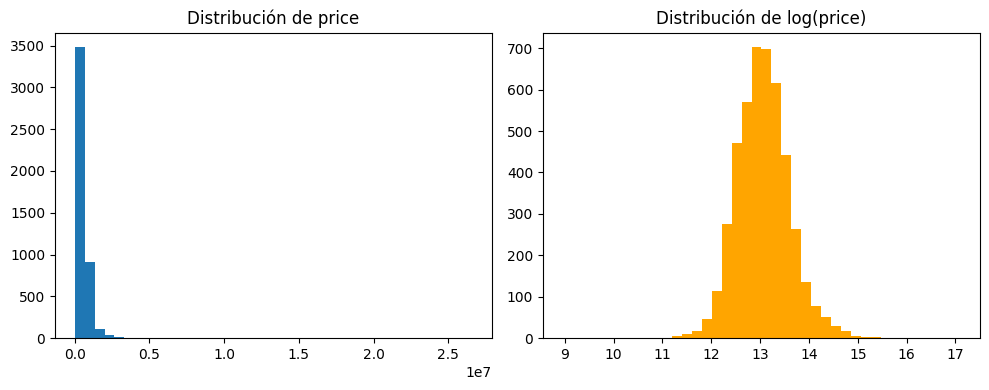

In [772]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["price"], bins=40)
plt.title("Distribución de price")

plt.subplot(1,2,2)
plt.hist(df["log_price"], bins=40, color='orange')
plt.title("Distribución de log(price)")

plt.tight_layout()
plt.show()


Once this was done, we decided it would be interesting to create some synthetic variables, namely “house_age” and “since_renovation,” to see if we could add value to our dataset.

In [773]:
df["house_age"] = 2014 - df["yr_built"]


df["since_renovation"] = np.where(
    df["yr_renovated"] > 0,
    2014 - df["yr_renovated"],
    df["house_age"]
)


display(df[["yr_built", "yr_renovated", "house_age", "since_renovation"]].head())

print("\nResumen estadístico de las nuevas variables:")
display(df[["house_age", "since_renovation"]].describe())


,yr_built,yr_renovated,house_age,since_renovation
0,1955,2005,59,9
1,1921,0,93,93
2,1966,0,48,48
3,1963,0,51,51
4,1976,1992,38,22



Resumen estadístico de las nuevas variables:


,house_age,since_renovation
count,4551.000000,4551.000000
mean,43.204351,28.909910
std,29.760073,26.852954
min,0.000000,0.000000
25%,17.000000,9.000000
50%,38.000000,20.000000
75%,63.000000,40.000000
max,114.000000,114.000000


Here we can see the distribution of our numerical data (AFTER SCALING BETWEEN 0-1) to see how they are positioned and detect possible outliers. We will accompany this with a correlation map and a correlation statistic with log(price) to see which variables may be most related to our price.

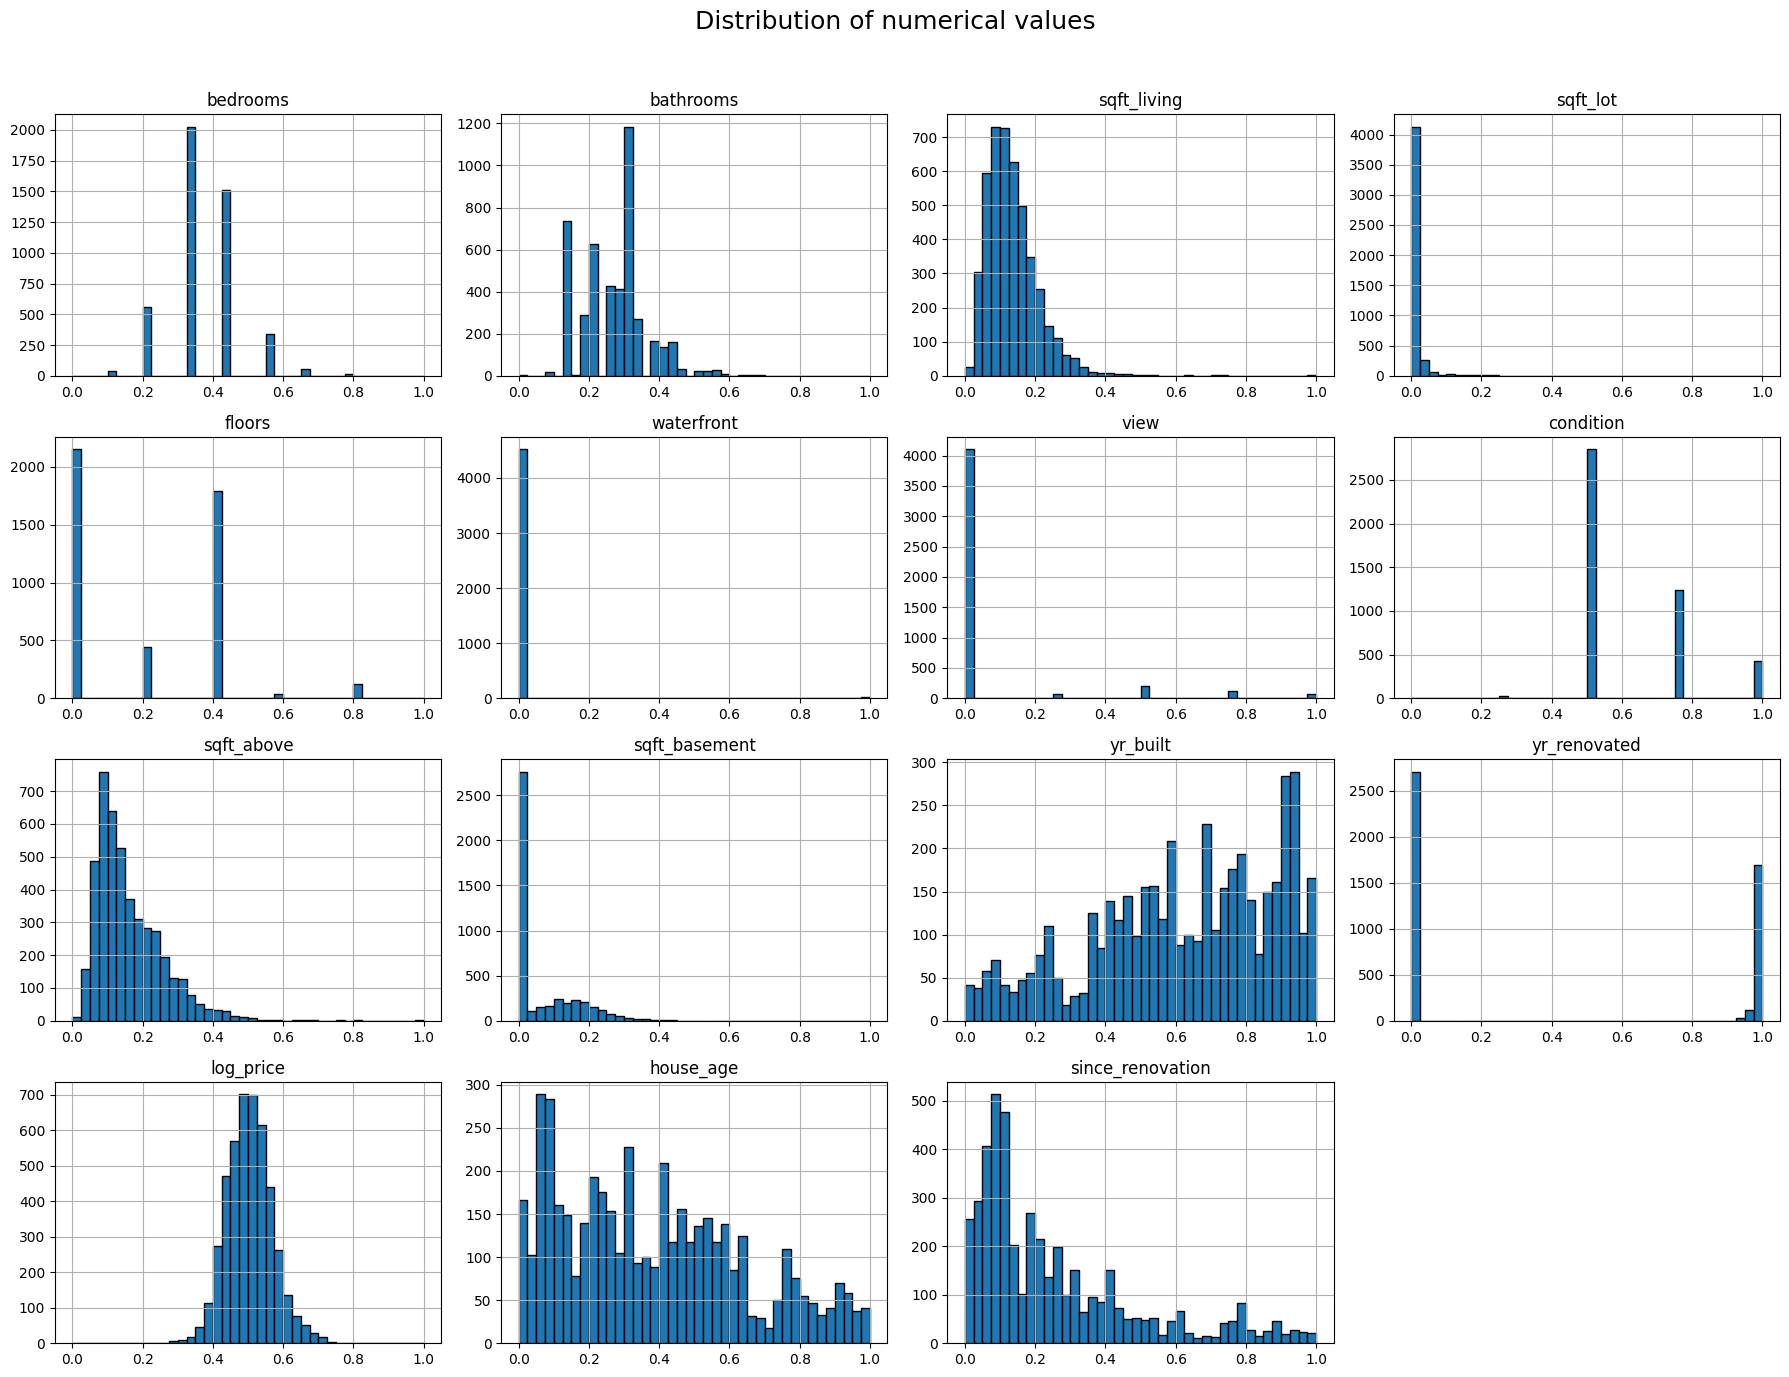

In [774]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['price'], errors='ignore')

scaler = MinMaxScaler(feature_range=(0, 1))
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df[numeric_cols].hist(figsize=(18, 14), bins=40, edgecolor='black')
plt.suptitle("Distribution of numerical values", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Correlations with log_price:


log_price           1.000000
price               0.677507
sqft_living         0.671307
sqft_above          0.582012
bathrooms           0.548583
bedrooms            0.355346
view                0.324040
sqft_basement       0.312636
floors              0.305319
waterfront          0.141863
sqft_lot            0.085856
condition           0.059256
yr_built            0.059101
since_renovation   -0.000911
house_age          -0.059101
yr_renovated       -0.063173
Name: log_price, dtype: float64

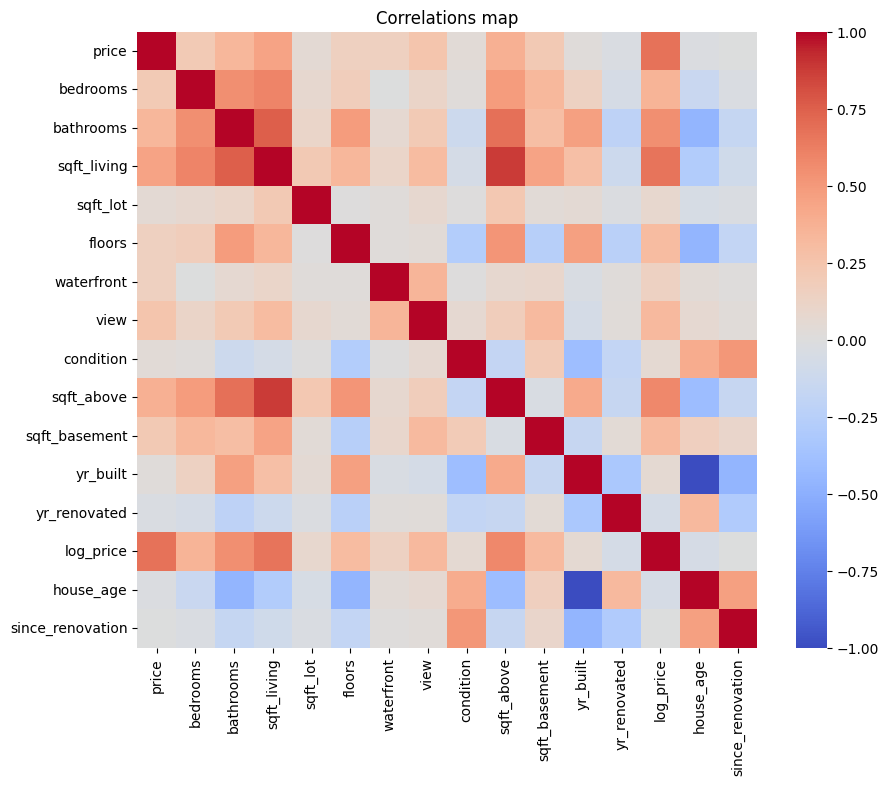

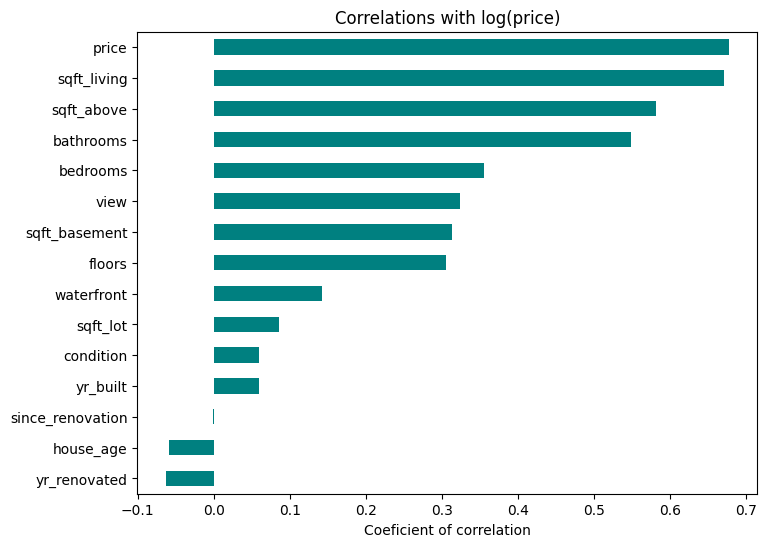

In [775]:
corr = df.corr(numeric_only=True)

corr_logprice = corr["log_price"].sort_values(ascending=False)

print("Correlations with log_price:")
display(corr_logprice)

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlations map")
plt.show()

plt.figure(figsize=(8,6))
corr_logprice.drop("log_price").sort_values().plot(kind="barh", color='teal')
plt.title("Correlations with log(price)")
plt.xlabel("Coeficient of correlation")
plt.show()


Let's make a graph of the distribution of the data where most of it is located for now, if we apply outlier removal to the data most related to log(price).

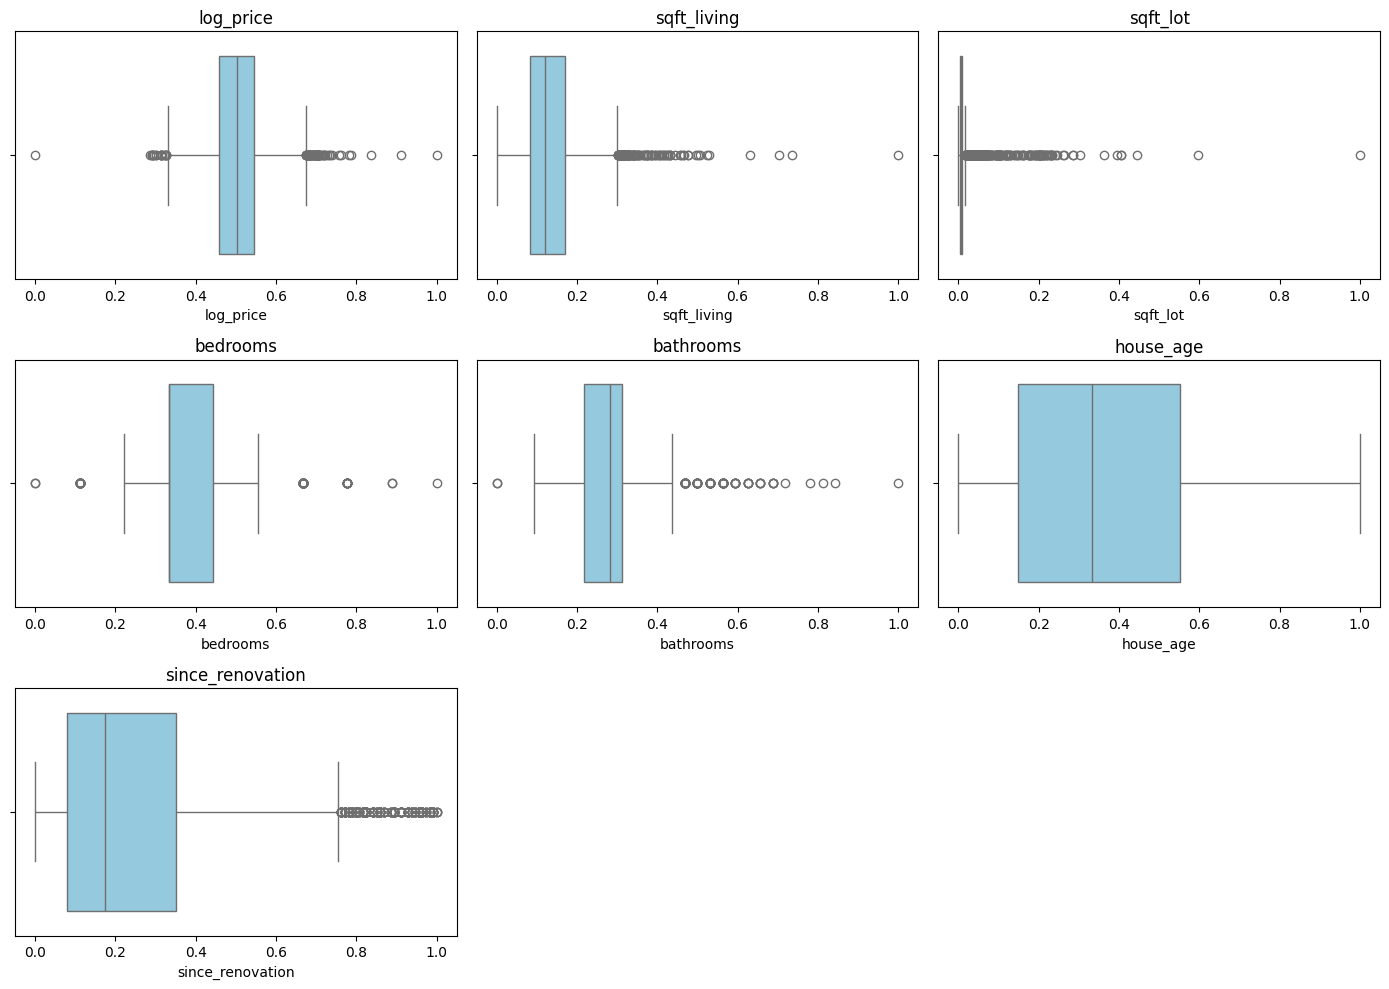

In [776]:
key_vars = ["log_price", "sqft_living", "sqft_lot", "bedrooms", "bathrooms", "house_age", "since_renovation"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(key_vars):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()


After printing the plots we apply the quartiles to delete outliers in the most important features that are log_price (the one that we want to predict) the sqft_living and sqft_lot that are the most correlated to log_price

log_price: Deleted 78 outliers
sqft_living: Deleted 97 outliers
sqft_lot: Deleted 498 outliers

Original Rows: 4551, Rows after cleaning: 3878


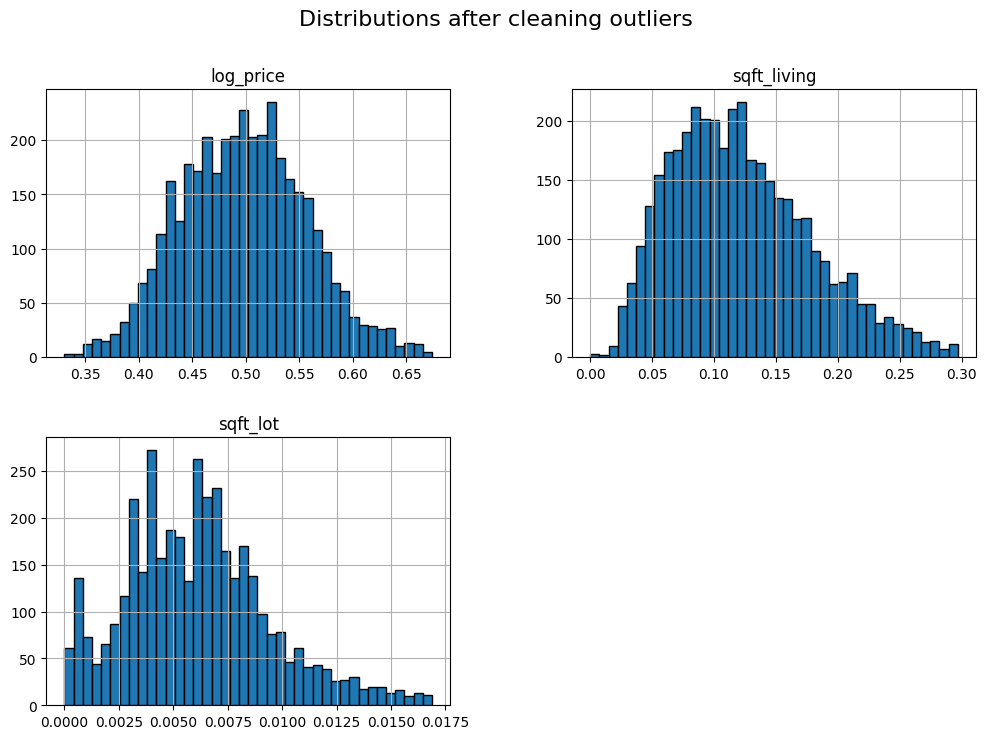

In [777]:

vars_to_clean = ["log_price", "sqft_living", "sqft_lot"]

df_clean = df.copy()


def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower) & (data[column] <= upper)]
    print(f"{column}: Deleted {len(data)-len(filtered_data)} outliers")
    return filtered_data

for col in vars_to_clean:
    df_clean = remove_outliers_iqr(df_clean, col)

print(f"\nOriginal Rows: {len(df)}, Rows after cleaning: {len(df_clean)}")

df_clean[vars_to_clean].hist(figsize=(12,8), bins=40, edgecolor='black')
plt.suptitle("Distributions after cleaning outliers", fontsize=16)
plt.show()


In [778]:
print(df_clean.head())

      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  313000.0  0.333333    0.18750     0.073652  0.006775     0.2         0.0   
2  342000.0  0.333333    0.25000     0.118451  0.010534     0.0         0.0   
3  420000.0  0.333333    0.28125     0.123766  0.006885     0.0         0.0   
4  550000.0  0.444444    0.31250     0.119210  0.009186     0.0         0.0   
5  490000.0  0.222222    0.12500     0.038724  0.005348     0.0         0.0   

   view  condition  sqft_above  sqft_basement  yr_built  yr_renovated  \
0   0.0       0.50    0.107301       0.000000  0.482456      0.995531   
2   0.0       0.75    0.172566       0.000000  0.578947      0.000000   
3   0.0       0.75    0.069690       0.207469  0.552632      0.000000   
4   0.0       0.75    0.085177       0.165975  0.666667      0.989076   
5   0.0       0.50    0.056416       0.000000  0.333333      0.990070   

        city  statezip  log_price  house_age  since_renovation  
0  Shoreline  WA 9813

We have deleted aproximatedly 15% of the data to delete outliers

## DataSplitting

In [779]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [780]:
X = df_clean.drop(columns=["log_price", "price"], axis = 1)
y = df_clean["log_price"]


In [781]:
X = pd.get_dummies(X, drop_first=True)
X = X.astype(float)


In [782]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### MLR

In [783]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

y_train_pred = mlr.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
r_train = np.corrcoef(y_train, y_train_pred)[0, 1]

print(f"Resultados TRAIN:")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"MAPE: {mape_train:.2%}")
print(f"R²: {r2_train:.4f}")
print(f"Coeficiente de Pearson (r): {r_train:.4f}")



Resultados TRAIN:
MSE: 0.0005
RMSE: 0.0228
MAE: 0.0166
MAPE: 3.41%
R²: 0.8502
Coeficiente de Pearson (r): 0.9221


/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [784]:
y_pred = mlr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


r = np.corrcoef(y_test, y_pred)[0, 1]
print(f"Coeficiente de Pearson (r): {r:.4f}")

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")
print(f"R²: {r2:.4f}")

Coeficiente de Pearson (r): 0.9082
MSE: 0.0006
RMSE: 0.0246
MAE: 0.0175
MAPE: 3.54%
R²: 0.8246


/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/toni/Documents/MESIIA/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


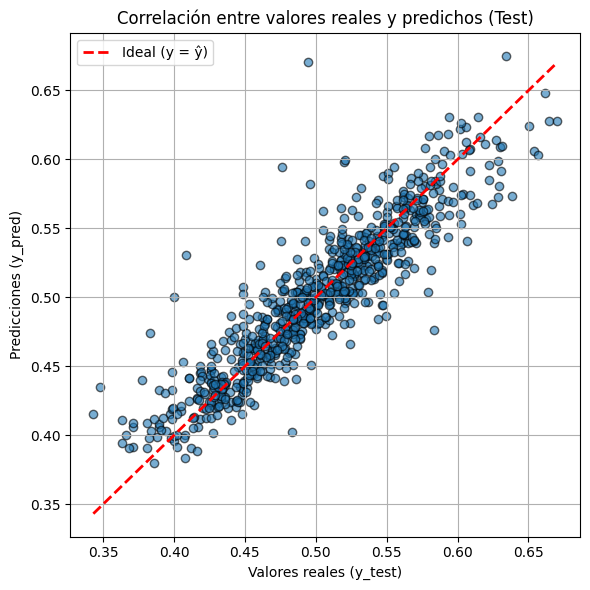

In [785]:
# --- Gráfico de correlación ---
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Ideal (y = ŷ)')
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Correlación entre valores reales y predichos (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### NN BP Pytorch

In [786]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [787]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [788]:
model = NeuralNetwork(n_features=X_train.shape[1])
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=133, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


It is important to change all the "True/Flase" values of the one-hot encoding to 0-1 in order to transform data to tensors

In [789]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

In [790]:
epochs = 400

train_losses = []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Entrenamiento
for epoch in range(epochs):
    # Forward
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()  # reiniciar gradientes
    loss.backward()        # calcular gradientes
    optimizer.step()        # actualizar pesos

    train_losses.append(loss.item())

    # Mostrar progreso
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [20/400], Loss: 0.009528
Epoch [40/400], Loss: 0.001763
Epoch [60/400], Loss: 0.000958
Epoch [80/400], Loss: 0.000798
Epoch [100/400], Loss: 0.000743
Epoch [120/400], Loss: 0.000712
Epoch [140/400], Loss: 0.000684
Epoch [160/400], Loss: 0.000660
Epoch [180/400], Loss: 0.000639
Epoch [200/400], Loss: 0.000621
Epoch [220/400], Loss: 0.000605
Epoch [240/400], Loss: 0.000590
Epoch [260/400], Loss: 0.000577
Epoch [280/400], Loss: 0.000565
Epoch [300/400], Loss: 0.000555
Epoch [320/400], Loss: 0.000545
Epoch [340/400], Loss: 0.000537
Epoch [360/400], Loss: 0.000530
Epoch [380/400], Loss: 0.000523
Epoch [400/400], Loss: 0.000517


In [791]:
# Predicciones del modelo
model.eval()  # modo evaluación (sin dropout, etc)
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()

# Convertir a numpy si hace falta
y_true = y_train_tensor.numpy()

# Calcular R²
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_true, y_pred_train)
mse = mean_squared_error(y_true, y_pred_train)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")


R²: 0.8516
MSE: 0.0005


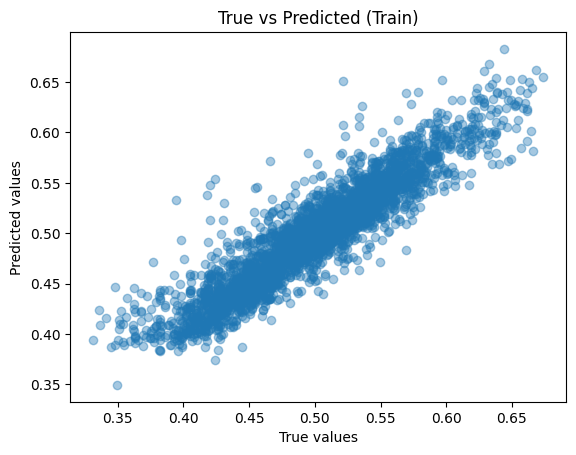

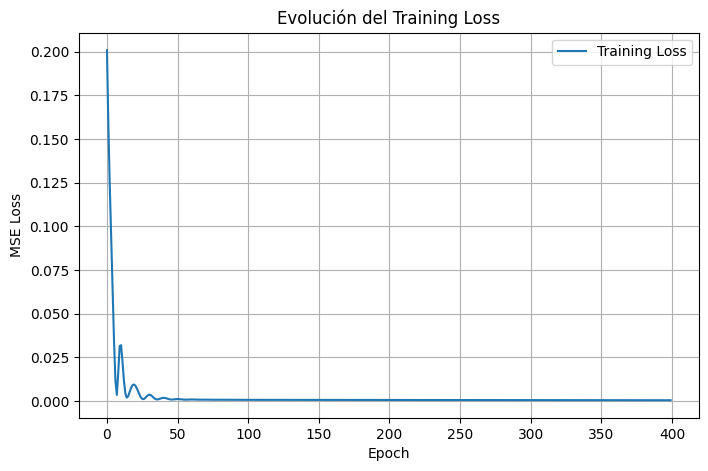

In [792]:
plt.scatter(y_true, y_pred_train, alpha=0.4)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True vs Predicted (Train)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Evolución del Training Loss")
plt.legend()
plt.grid(True)
plt.show()


In [793]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [794]:
model.eval()  # Modo evaluación: desactiva dropout, batchnorm, etc.

with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)

print(f"Test Loss (MSE): {test_loss.item():.6f}")


Test Loss (MSE): 0.000614


In [795]:
from sklearn.metrics import r2_score

# Convertimos a numpy
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_test.numpy()

r2 = r2_score(y_test_np, y_pred_np)
print(f"R² en test: {r2:.4f}")


R² en test: 0.8215
